# Labo 3 - ARN

In [1]:
import pandas as pd

mice_eeg = pd.read_csv('./pw3_data/EEG_mouse_data_1.csv')
mice_eeg2 = pd.read_csv('./pw3_data/EEG_mouse_data_2.csv')
df = pd.concat([mice_eeg, mice_eeg2], ignore_index=True)

#mice_eeg3 = pd.read_csv('./pw3_data/EEG_mouse_data_test.csv')

## 1. Introduction

We take the first 25 features as they are contain the biggest occurences count.

In [2]:
input_data = df.iloc[:, 1:26].to_numpy()
input_data

array([[9.12315038e-06, 1.36561480e-05, 1.28317985e-05, ...,
        1.31561699e-06, 1.88253500e-06, 3.55532102e-07],
       [9.79506089e-06, 9.57394018e-06, 1.10242275e-05, ...,
        8.95866570e-07, 2.86503928e-07, 8.28093517e-07],
       [1.08095899e-05, 7.67086231e-05, 3.43861986e-05, ...,
        3.17965398e-07, 3.83331752e-07, 2.46632392e-07],
       ...,
       [1.62138773e-05, 2.84640695e-05, 3.14285776e-05, ...,
        1.22219165e-07, 1.27733472e-07, 2.25666255e-07],
       [1.28606980e-05, 1.36000401e-05, 1.97660529e-05, ...,
        8.17007848e-07, 6.63020742e-07, 9.61559003e-07],
       [3.54205244e-06, 5.87464763e-06, 1.07878578e-05, ...,
        3.68524246e-06, 7.30184750e-07, 1.33459349e-06]])

# Normalisation


In [3]:
# Cut in 3 folds (1/3 for test and 2/3 for training)
# shuffle d'abord avant de découper
#  normaliser tout fit
# partager

import keras
from keras import layers
from sklearn.model_selection import KFold
import matplotlib.pyplot as pl

pl.clf()

keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)
for i, (train_index, test_index) in enumerate(kf.split(df)):
    print(str(i) + ' ' + str(train_index) + ' ' + str(test_index))
# See training 2 cells below

2024-04-17 12:21:11.472317: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 12:21:11.473360: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 12:21:11.659636: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 12:21:12.306762: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 12:21:14.929785: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

0 [    0     2     3 ... 40860 40861 40862] [    1     8    15 ... 40854 40856 40857]
1 [    0     1     4 ... 40859 40860 40862] [    2     3     5 ... 40855 40858 40861]
2 [    1     2     3 ... 40857 40858 40861] [    0     4     6 ... 40859 40860 40862]


<Figure size 640x480 with 0 Axes>

In [4]:
# Configure and setup our MLP
# Source: From the notebook 5. See 'Changed: '
def create_model():
  mlp = keras.Sequential([
      layers.Input(shape=(25,)), # Changed: shape=(25,) instead of 2
      layers.Dense(8, activation="tanh"), # Try different numbers of hidden neurons here (e.g. 2, 4, 8, 32, 128)
      # Changed: todo try to change the amount of layers and perceptrons per layer
      layers.Dense(3, activation="softmax")   # output
  ])

  # Experiment with hyperparameters here:
  # momentum: [0, 0.8, 0.9, 0.99]
  # learning_rate: [0.1, 0.01, 0.001, 0.0001]
  mlp.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.99),
      loss="mse",
  )

  return mlp

mlp = create_model()
mlp.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235 (940.00 B)

 Trainable params: 235 (940.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
history_list = []
trained_mlp = []

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
scaler = StandardScaler()

encoder = OneHotEncoder(sparse_output=False)
encoded_states = encoder.fit_transform(pd.DataFrame(df['state']))  # Transform and encode the states

print(encoded_states)
for i, (train_index, test_index) in enumerate(kf.split(input_data)):
  print(str(i) + ' ' + str(train_index) + ' ' + str(test_index))
  
  # We need to create a new model every time otherwise fit will continue previous training
  mlp = create_model()
  
  train_input = scaler.fit_transform(input_data[train_index])
  test_input = scaler.fit_transform(input_data[test_index])
  
  history = mlp.fit(
      x=train_input, 
      y=encoded_states[train_index],  # Use the encoded states for training
      validation_data=(test_input, encoded_states[test_index]),
      epochs=15
  )

  history_list.append(history)
  trained_mlp.append(mlp)


[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
0 [    1     3     4 ... 40860 40861 40862] [    0     2     6 ... 40853 40854 40858]
Epoch 1/15
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1430 - val_loss: 0.0720
Epoch 2/15
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0730 - val_loss: 0.0672
Epoch 3/15
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0685 - val_loss: 0.0657
Epoch 4/15
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0670 - val_loss: 0.0650
Epoch 5/15
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0661 - val_loss: 0.0646
Epoch 6/15
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0655 - val_loss: 0.0642
Epoch 7/15
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0650 - val_loss: 0.0639
Epoch 8/15
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0647 - val_loss: 0.0636
Epoch 9/15
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0643 - val_loss: 0.0634
Epoch 10/15
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0

In [6]:
trained_mlp[0]

<Sequential name=sequential_1, built=True>

# Plot training history

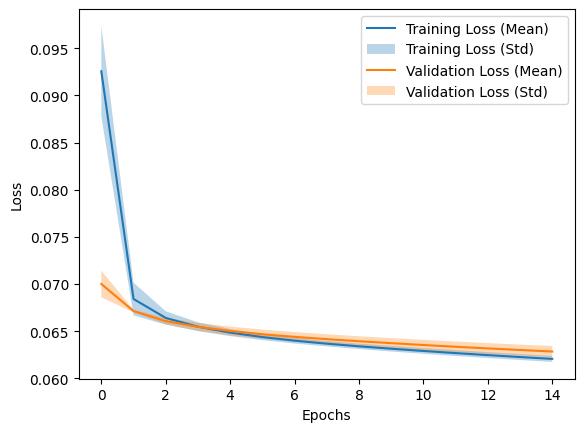

In [7]:
import numpy as np

train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

# Performances

  1/426 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step

/home/sam/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/sam/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


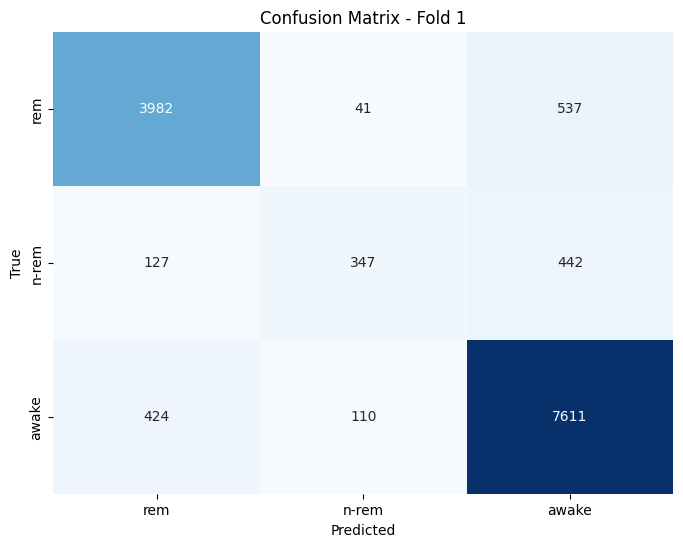

F1 Score - Fold 1: 0.7587451529435505
 22/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  

/home/sam/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/sam/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


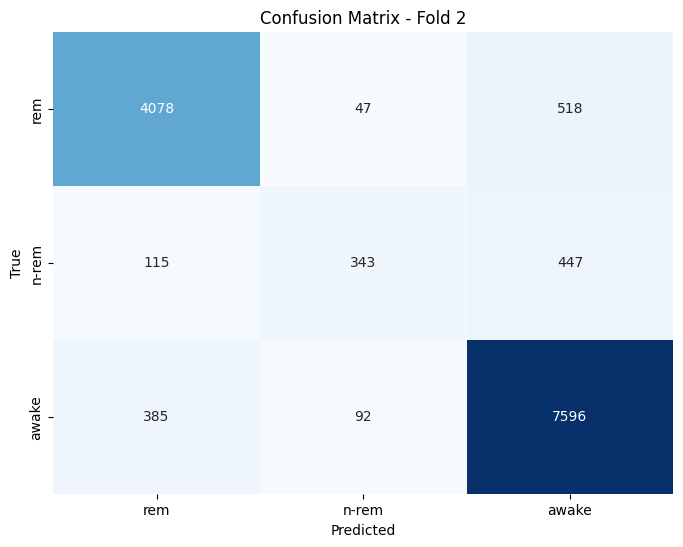

F1 Score - Fold 2: 0.7641351663991115


/home/sam/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/sam/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


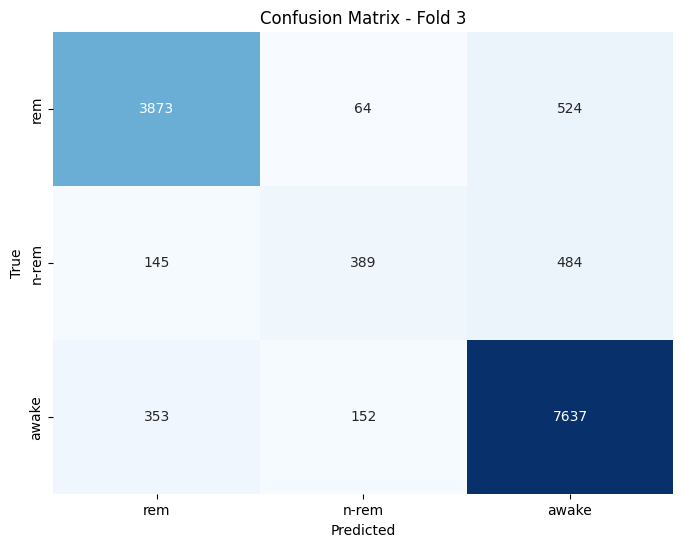

F1 Score - Fold 3: 0.7554226627069417


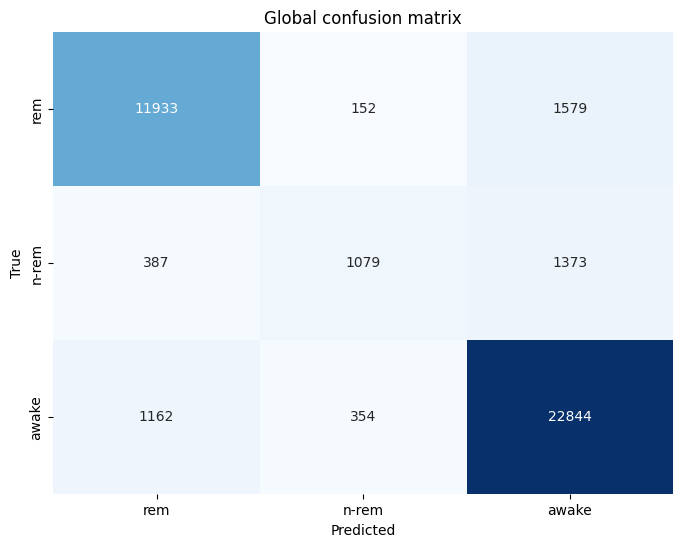

Mean F1 Score across all folds: 0.7594343273498678


In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    pl.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["rem","n-rem","awake"], yticklabels=["rem","n-rem", "awake"])
    pl.title(title)
    pl.xlabel('Predicted')
    pl.ylabel('True')
    pl.show()

f1_scores = []
mean_confusion_matrix = np.zeros((3, 3))

for i, (train_index, test_index) in enumerate(kf.split(input_data)):
    
    # Normalize
    train_input = scaler.fit_transform(input_data[train_index])
    test_input = scaler.transform(input_data[test_index])

    # Transform target variable
    train_output = encoder.transform(df['state'].iloc[train_index].values.reshape(-1, 1))
    test_output = encoder.transform(df['state'].iloc[test_index].values.reshape(-1, 1))
    
    # Get feature names from encoder categories
    feature_names = encoder.get_feature_names_out(['state'])
    train_output_df = pd.DataFrame(train_output, columns=feature_names)
    test_output_df = pd.DataFrame(test_output, columns=feature_names)

    # Evaluate the trained model on the test fold
    predictions = trained_mlp[i].predict(test_input)
    true_labels = np.argmax(test_output, axis=1)  # Get the index of the maximum value as the true labels
    predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the maximum value as the predicted labels

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    mean_confusion_matrix += cm

    # Compute confusion matrix and plot
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')

    # Compute F1 score
    f1 = f1_score(true_labels, predicted_labels, average='macro')  # Use macro averaging for multi-class classification
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")
